In [1]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.stats as stats
import pandas as pd
%matplotlib inline

### Brief Overview 

- The goal of this assignment is to practice some essential concepts covered in the statistical and probability and hypothesis testing sections

- The assignment is comprised of two problems: 1-hypothesis testing and  2- generative models and simulation. Both problems start by breaking down the problem into chunks that are meant to guide you through solving the problem bit-by-bit before asking you to replicate the analysis on a different question.

##### Instructions on answering the questions

* The only Python modules you are allowed to use in this assignment are those imported in the top cell
  * Those are:  matplotlib, `numpy`, `scipy` and `pandas`


* All your graphs should be labeled appropriately and should have a title
  * You can set your plot size using `plt.figure(figsize=(a,b))` where (a,b) are the dimensions of you plot



# PROBLEM 1
----

### Modeling Revenue from Memberships on a Training Website

* We are interested in modeling sales revenue over 2019 for a website that offers training using a membership model. In short, the website charges a monthly fee ($39.99) and enrollees can take as much time as needed to complete their training. Enrollees can quit the platform anytime without completing the training.

* The data provider knows that:
  * On average, females tend to complete training earlier than males
  * On average, females tend to quit less than males
  * Students have a small probability of dropping each month. The probability of dropping decays (declines) as the students get close to completing the training, i.e., the longer a student has paid, the less likely they are to give up on their investment and leave the platform before completing the training.
  
  * The site has seen a steady annual increase in memberships over the past five years. 
   * Specifically, the mean increase was 13% and the standard deviation %1.4
   * The expected increase in memberships is similar for next year.
   * In 2018,  90,316 people enrolled on the training site
  
* We have access to data from only 60,563 members in 2018
   
The data contains three columns:

| Column    | Description                                    |
|-----------|------------------------------------------------|
| member_id | unique identifier of the member                |
| gender    | M for male and F for female                    |
| status    | C for completed and Q for quit                 |
| mem_duration    | Total duration of the membership in Months |
  


Your task is to build a generative model, which can be used to estimate revenue for next year. However, before simulating data, we need to learn the parameters of the model and hypothesize about their underlying distributions. 


### Reading the Data 

* The data is stored in the file `sample_users.csv` in the data folder
* Use `pandas` to read in the data into a variable called `sample_users`
* Verify that the file contains information about 60,563 members


In [142]:
# Write your code here 
sample_users = pd.read_csv("data/sample_users.csv")
sample_users.shape

(60563, 4)

### Generative Model for our Simulations

Below is a description of the generative model we will use. Our model will simulate yearly sales in 4 steps:

  1. Simulate a likely number of enrollee based on $\mu=13$ and $\sigma =1.4$ increase from last year
  
  2. For each enrollee simulate whether the enrollee is going to:
  
    2.1 Quit the training:
      Generate a likely value representing the number of months or enrollment before quitting
      
    2.2 Complete the training:
      Generate a likely value representing the number of months or enrollment before completing the training

  3. Compute the revenue from memberships based on the total number of months of enrollment simulated for each member

This strategy is shown in the figure below



<img src="images/generative_model_diagram.png" alt="drawing" style="width:700px;"/>

### Estimating the 95% Confidence Interval of the Simulation

* We are not interested in a single value but the range of values in which the revenue lies 95% of the time.
 
* Therefore, we need to repeat the experiment above a large number of times to derive the 95% confidence interval
  * We will repeat the experiment 5000 times 



###  1. Generating the Number of Enrollees

 * The vendor expects  the number of enrollees for next year to be similar in scope to yearly increases observed in the past 
    * The increase should have a mean has a mean $\mu=13$% and a standard deviation of $\sigma =1.4$% 
 * Last year number of enrollees was 90,316, 

* Use  the Gaussian (normal) distribution to sample a likely number of clients for next year
  * This number will represent the number of clients in a single iteration of the generative model

* Save the value in a variable called `nb_enrollees`
 
  * Recall that you will need to convert the resulting value to an `int`.
  



In [52]:
# Write your code here 
next_year_mean = 1.13 * 90316 # mean is 113% of last years value
next_year_dev = next_year_mean * .014 # deviation is 1.4% of next years mean
nb_enrollees = int(np.random.normal(next_year_mean,next_year_dev,1)[0]) 
nb_enrollees


100850

### Compute the Proportion of People who Quit Training in the Population of Enrollees

* Use the data in to build a 98% confidence interval of the proportion of people who quit the training before completing.
  * You can generate a single instance of the rate of people who quit by dividing by the number of  people who quit (`status == "Q"` in the data) by the total number of people

* Will build a 98% confidence interval by computing the proportion in 5,000 bootstrap iterations of the data
   

* Assing the the the confidence interval tuple to a variable called `quit_prop_conf_int`
  * You can use `np.percentile` to compute the interval
  

In [53]:
# Write your code here 
#quit_rate = (sample_users['status'] == 'Q').sum() / sample_users.shape[0]

quit_prop_conf_int = []
#use quit_rate to 
for _ in range(5000):
    data_sample_1000_bootstrap = sample_users.sample(1000)
    quit_rate = (data_sample_1000_bootstrap['status'] == 'Q').sum()/ data_sample_1000_bootstrap.shape[0]
    quit_prop_conf_int.append(quit_rate)
#98% confidence interval means we want percentile from 1 to 99
np.percentile(quit_prop_conf_int, (1, 99))

array([0.325, 0.397])


### 2. Generating a Radom Quitting Probability

The 98% confidence interval tells us that we are 98% sure that the true parameter is in that interval. Thefore, to inject this uncertainty into our model, we will estimate the number of people who quit in each iteration by randomly picking a value from that confidence interval. 
 
  * Use `np.random.uniform(min, max)` to randomly pick a value in the interval.
  * ex. if the bounds of your quit_prop_conf_int are (0.2, 0.3), a possible value is 
  
```python  
  np.random.uniform(0.2, 0.3)
  >>> 0.225
  # this is equivalent to 
  # np.random.uniform(quit_prop_conf_int[0], quit_prop_conf_int[1])
```

Save the value in a variable called `quit_prop`

In [55]:
# Write your code here
quit_prop = np.random.uniform(quit_prop_conf_int[0], quit_prop_conf_int[1])
quit_prop

0.3701287005278977

### 3. Simulating Numbers for People who  Quit and those who Complete the Training


* Use the variable `nb_enrollees` and `quit_prop` to determine the number of people who are going to complete the training and the numer of enrollees who will quit

* Save the value in `nb_enrollees_finish` and `nb_enrollees_quit` 

  * Recall that the resulting values are integers not float.
  * Verify that
  

```
nb_enrollees_finish + nb_enrollees_quit == nb_enrollees

```


In [60]:
# Write your code here 
nb_enrollees_quit = int(nb_enrollees * quit_prop) #make it as an int to represent whole users
nb_enrollees_finish = nb_enrollees - nb_enrollees_quit

nb_enrollees_finish + nb_enrollees_quit == nb_enrollees

True

### Determining the Number of Payments Enrollees Make Before Quitting

* Here we will be modeling the number of months that a person remains enrolled before eventually quitting

* Recall that the probability of dropping declines as the students get close to completing the training
  * The longer the student has paid, the less likely they are to drop out
  * A person is more likely to quit on the first month of enrollment than any other month 
  *  The probability of unenrolling during month $t$ is always higher than the probability of unenrolling during month $t+1$
 
 
* The illustrations A, B and C below are all valid representation of the probability distribution, as we described it above.
  *  For illustration purposes, the  function is represented in the range [1, 10]

<img src="images/decay.png" alt="drawing" style="width:1400px;"/>

### Identifying the Most Likely Parameters

* This three figure all represent the  exponential probability distributions
  https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.expon.html
  
  
* While we haven't covered this distribution in class, all we need to know is that this distribution has two parameters:
  * `loc`, which represents  the value at which the function has its maximum
  * `scale`, which represents the "inverse rate of decay"
    * the large the value, the slower the function is to reach a probability of 0.
  
* In the example above, all three distributions have a `loc` of 1
  * The users are most likely to quit during the first month than at any other time
* All three curves have a different scale parameter. The example A, B and C have inverse decays   (`scale`) of `0.2`, `1` and `200` respectively

* Examples of how to use the `expon` probability distribution are given below


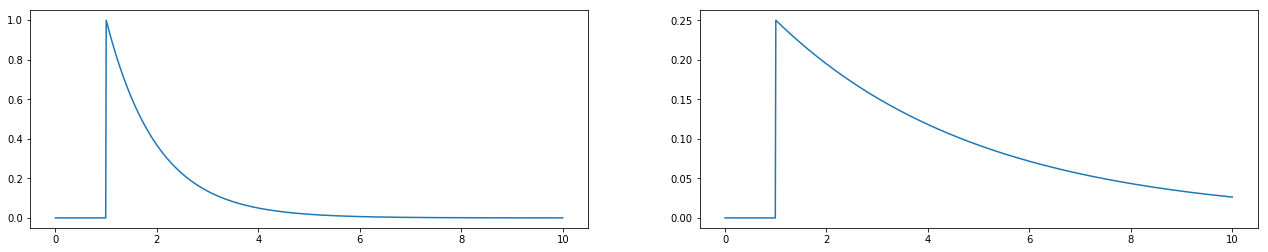

In [61]:
plt.figure(figsize=(22,4))
x = np.linspace(0, 10, 1000)

y_dist_1 = stats.expon(1, 1)
y_dist_2 = stats.expon(1, 4)


plt.subplot(1, 2, 1)
plt.plot(x, y_dist_1.pdf(x), label="$a=0.2$")


plt.subplot(1, 2, 2)
plt.plot(x, y_dist_2.pdf(x), label="$a=1$")



In [62]:
# Sampling 7 values from stats.expon with `loc=1` and `scale=2`

stats.expon(1, 2).rvs(7)

array([3.32052248, 6.21098507, 2.58779286, 2.95481022, 1.54009928,
       1.92606973, 1.63589635])

### Identifying the rate using Maximum Likelihood (ML)

* Which param of the exponential maximizes the log-likelihood of our data?
  * We will set loc=1given that the users are most likely to unenroll during the first month.
  * Which value of `scale` has the maximizes the log-likelihood value of the data we have?
  
  
* Before we answe this question, compute the log-likelihood of this dataset using a `scale` value of 5
 * Recall that the oversed data here is the number of months a person remains enrolled before eventually quitting
   * Make sure that your data is the `mem_duration` for individuals with `status=="Q"`

* Also, to compute the log-likelihood of the data [2,1,2,3,4] and `location=1` and `scale=5`, we write:


```python
    log_pdfs = stats.expon(1, 4).logpdf([2,1,2,3,4])
    sum(log_pdfs)
    # or simply 
    # sum(stats.expon(1, 4).logpdf([2,1,2,3,4]))
```

* Note that above we chain operations by first building the distribution using `stats.expon(1, 4)` and, which we subsequently use to call the method `logpdf([2,1,2,3,4])`

In [123]:
# Write your code here 
mem_duration_quitters = sample_users.loc[sample_users['status'] == 'Q']['mem_duration'].reset_index(drop=True)

log_pdfs = stats.expon(1, 4).logpdf(mem_duration_quitters)
sum(log_pdfs)

-60839.461738190046

# Computing the Inverse Decay Using the Maximum Likelihood

* Compute and plot the log-likelihood of the parameters given the data

  * To answer the questions, we will compute the log ML for each possible `scale` value between 1 and 50

* Yout graph should look like the 



* The X-axis represents possible distribution params
* The Y-axis represents the log-likelihood of your data

* Notes:
  * I clearly marked the graph to indicate where likelihood is maximal
  * The x-axis ticks are intentionally missing. Make sure yours are not.

<img src="images/ML.png" alt="drawing" style="width:1400px;"/>

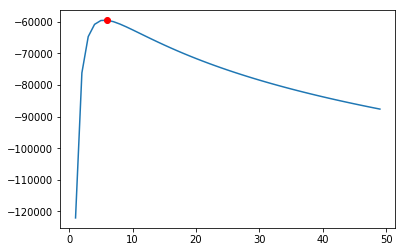

In [136]:
# Write your code here 
max_likelihood_data = []
for i in range(50):
    max_likelihood = stats.expon(1, i).logpdf(mem_duration_quitters)
    max_likelihood_data.append(sum(max_likelihood))
# plot all data from max_likelihoodata
plt.plot(max_likelihood_data)
# plot the max value form max_likelihood_data as a dot

plt.plot(np.nanargmax(max_likelihood_data),np.nanmax(max_likelihood_data),'ro')
plt.show()

### 4. Simulating Users Unenrolling from the Training

* Using the exponential distribution and the parameter we determined using the maximum likelihood, simulate the number of months the users who quit, is likely to have stayed before leaving the platform

* To simulate the number of months a user may have remained unrolled before quitting, we simply sample from the exponential using the `scale` param identified above. Ex. if your scale is 4, you can use: 

```python 
    scale =4
    nb_users = 1
    stats.expon(1, scale).rvs(nb_users)
    array([ 2.68001742])
    
```

* The value above tell us for the user we simulated stayed on 2.6 months before quitting. 
  *  Simply change the value of nb_users to simulate multiple users

* Since users pay monthly, you can round up the values to the closest integer
  * Compute the ceiling using `np.ceil`

* Simulate the number of months enrolled for all users in `nb_enrollees_quit`  
 * Save the value to a variable called `months_payed_before_quitting`
  

In [139]:
# Write your code here 
# use the index of the maximum value as our scale
months_payed_before_quitting = []
scale = np.nanargmax(max_likelihood_data)
nb_users = 1
months_payed_before_quitting = np.ceil(stats.expon(1, scale).rvs(nb_enrollees_quit))
months_payed_before_quitting

array([ 2.,  4.,  2., ..., 12.,  6., 12.])

### Modeling the Membership Duration for Enrollees who Complete the Training

* We will use a similar approach to derive the duration of enrollment for users who completed the training

  *  Here we are not concerned by the gender difference as instructed by the vendor
    
* Plot a KDE of the duration of enrollment for enrollees who completed the training. 
  * Your graph should look like the following
 

<img src="images/kde.png" alt="drawing" style="width:600px;"/>

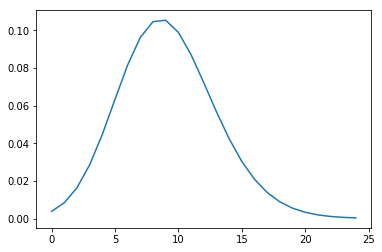

In [172]:
# Write your code here 
x_values = np.arange(0, 25, 1)
users_complete_duration = sample_users.loc[sample_users['status'] == 'C']['mem_duration'].reset_index(drop=True)

kde = sp.stats.gaussian_kde(users_complete_duration, bw_method=0.8)
densities = kde.evaluate(x_values)
plt.plot(x_values, densities)
plt.show()

### Visually identifying mean training completion time

* Based on the KDE above, how long does it take, on average, to complte the training?



### Write your answer here
it looks as though <strong>9</strong> months is average to complete training


### Modeling the Membership Duration for Enrollees who Complete the Training - Cont'd 

* The distribution is skewed 

  * After looking at Encyclopedia of probability distributions, you realize your KDE looks similar to a gamma distribution 
  
   https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gamma.html

* The distribution takes a single parameter $a$

  * $a$ is called the shape parameter

  * See the documentatation of  `stats.gamma` in the `scipy` package

* Below are a couple of examples of usage of stats.gamma
  * The first uses a shape parameter $a=2$ and the second uses a shape parameter $a=8$
  
<img src="images/two_gammas.png" alt="drawing" style="width:1000px;"/>


### Computing the Maximum Likelihood Value of the Parameter $a$

* Use the Maximum Likelihood to identify the value of the parameter $a$ that maximizes the log-likelihood 
    
  * Compute and plot the log-likelihood for the values between 1 and 25
  
    * The X-axis represents possible distribution params
    * The Y-axis represents the log-likelihood of your data
  * Recall that tour data consists of the `mem_duration` for users where `status == "C"`
  
* Notes:
  * I clearly marked the graph to indicate where likelihood is maximal
  * The x-axis ticks are intentionally missing. Make sure yours are not.
  * You can  use the `logpdf` directly on the `gamma(x)` object 
  
<img src="images/ML_gamma.png" alt="drawing" style="width:800px;"/>



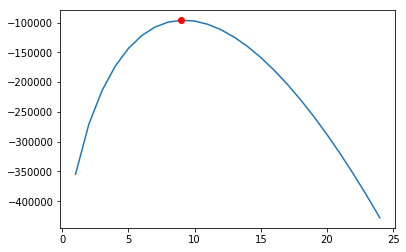

"\nmax_likelihood_data = []\nfor i in range(50):\n    max_likelihood = stats.expon(1, i).logpdf(mem_duration_quitters)\n    max_likelihood_data.append(sum(max_likelihood))\n# plot all data from max_likelihoodata\nplt.plot(max_likelihood_data)\n# plot the max value form max_likelihood_data as a dot\nplt.plot(np.nanargmax(max_likelihood_data),np.nanmax(max_likelihood_data),'ro')\nplt.show()\n"

In [176]:
# Write your code here
max_likelihood_alpha = []
for i in range(25):
    max_alpha = stats.gamma(i).logpdf(users_complete_duration)
    max_likelihood_alpha.append(sum(max_alpha))
plt.plot(max_likelihood_alpha)
plt.plot(np.nanargmax(max_likelihood_alpha),np.nanmax(max_likelihood_alpha),'ro')
plt.show()

### Computing the Maximum Likelihood Value of the Parameter $a$ - Cont'd


* What is the value that maximizes the likelihood?
 * Save the value in `months_payed_before_completion`
 
* Does this value agree with your findings from visually inspecting the KDE graph above?


In [ ]:
# Write you code here 


In [ ]:
### Write you answer here 



### 5. Simulating Users Completing the Training


* Using the gamma distribution and the parameter $a$ determined above, simulate the number of months it has taking users to finish the training

* To simulate the number of months a user may have remained unrolled before completing the training we simply sample from the gamma using the param $a$ identified above.

* Ex. if your $a$ = 5, you can use: 

```python 
    scale =4
    nb_users = 1
    stats.gamma(1, months_payed_before_completion).rvs(nb_users)
    array([ 5.112342])
    
```

* The value above tells us for the user we simulated stayed on 5.1 months before quitting 
  *  Simply change the value of nb_users to simulate multiple users

* Since users pay monthly, you can round up the values to the closest integer
  * Compute the ceiling using `np.ceil`

* Simulate the number of months enrolled for all users in `nb_enrollees_finish`  
 * Save the value to a variable called `months_payed_before_finishing`
  

In [ ]:
# Write your code here 


### 6. Simulating Revenue for a Single Iteration
* Compute the total revenue for this iteration as the total months paid by users who completed the training and those who quit, times the monthly fee
  * The total months paid by users who completed the training is saved in `months_payed_before_finishing`
  * The total months paid by users who completed the training is saved in `months_payed_before_quitting`
  * The monthly fee is 39.99


In [ ]:
# Write you code here


### Build a 95% Confidence Interval for the Revenue

* Repeat the simulation above 5000 times to build a confidence interval. The steps you'll need to repeat are those described in text cells with the following headers:
    
  1. Generating the Number of Enrollees
  2. Generating a Radom Quitting Probability
  3. Simulating Numbers for People who  Quit and those who Complete the Training
  4. Simulating Users Unenrolling from the Training
  5. Simulating Users Completing the Training
  6. Simulating Revenue for a Single Iteration


    
* The computation may take a few minutes to complete

In [ ]:
# Write you code here

### Taking into account gender differences 

* Repeat the analysis above while taking into consideration the differences between males and females. 
  
* Let's assume that the `quit_prop` is the same across gender

* You'll need two additional parameters

  * the proportion of males/females in the population of enrollees who quit the training, call it `male_female_prop_quit`
     * This is the param that you'll use to decide whether the person who unenrolls is a Male or Female

  * The proportion of males to females in the population of enrollees who complete the training, call it `male_female_prop_finish`
    * This is the param that you'll use to decide whether the person who unenrolls is a Male or Female

* Rather than having a single parameter `scale` for the inverse decay of the exponential distribution, you will now have two parameters, one for males and a second for females
* Rather than having a single shape parameter $a$ for gamma distribution, you will now have two parameters, one for males and a second for females

* Provide your code below



In [ ]:
# Write you code here 




### Conclusion


* Which do you think is the most accurate model, the one that takes into account the gender differences of the one that does not? Justify your answer.




# PROBLEM 2
----

###  Average Medicare Payment and Hypothesis Testing 


We have access to Average Medicare Payment for 163,065 hospitals nationally. The average medicare payment are classified according to `DRG Definitions`; those are diagnostic categories that describe classes of services the hospital rendered. For instance, the average Medicare Payment at  THE QUEENS MEDICAL CENTER for the diagnostic category  "917 - POISONING & TOXIC EFFECTS OF DRUGS W MCC" was $15,305.21.


We are interested in comparing the avg. payments across states to assess whether they are similar or not, regardless of diagnostic category. Naturally, by different, we are interested in seeing whether the difference is statistically significant.




### Loading  the data

* Load the data into a variable called `payment_data`
  * Select only the columns ['DRG Definition', "Provider Name", 'Provider State', 'Average Medicare Payments']
  * Rename these columns as ['diagnostic', 'name', 'state', 'avg_medicare_payment']



In [ ]:
# Write you code here



### Average Medicare Payment Value

* Compute the mean average medicare payment value for Idaho (ID) and Hawaii (HI). 

* Based on the observed means, do you think that the difference in mean average medicare payment between both states is statistically significant?

  * Justify your answer

In [ ]:
# Write you code here



# FYI: Which are the Costliest Categories

* Post-surgery infections are the categories with the highest Medicare payments cost,
  * The most expensive category is `853 - INFECTIOUS & PARASITIC DISEASES W O.R. P....` 
    * there were 15 discharges in NY's  WESTCHESTER MEDICAL CENTER, with an average medicare payment of $133,177 
    
    * there were 86 discharges in LA's CEDARS-SINAI MEDICAL CENTER with an average medicare payment of $87437.8
  
* The overall cost of surgical site infection alone in the US is an estimated $3.5 to $10 billion annually.



In [ ]:
data[data["DRG Definition"].str.contains("INFECTIOUS")].sort_values("Average Medicare Payments", ascending=False).head()

### Skewed Data

* The payments data in Idaho and Hawaii are highly skewed; i.e., most payments are less than $20k, with a few rare payments above. 
  
  * Most payments are below $15k$, with some up to $60k$ in both states

* See graphs below



In [ ]:
plt.figure(figsize=(22,4))
plt.subplot(1, 2, 1)
_ = plt.hist(payment_data[payment_data["state"] == "ID"]["avg_medicare_payment"])
plt.title("avg_medicare_payment in ID")
plt.subplot(1, 2, 2)
_ = plt.hist(payment_data[payment_data["state"] == "HI"]["avg_medicare_payment"])
plt.title("avg_medicare_payment in Hawaii")

### Log-transforming the data


* As discussed in class, data which follow bell-shaped distributions tend to be easier to work with in hypothesis testing

* Compute the log (base 10) of the `avg_medicare_payment` and the results in a new column called `log_avg_medicare_payment`



  


In [1]:
# Write you code here



# Plotting the Hawaii KDE

* Plot the `log_avg_medicare_payment` KDE for Hawaii 
 * You can use the `gaussian_kde` function from `scipy`'s `stats` module
    
* Your curve should look like the one below

* Notice that: 
  * The KDE is smooth (as opposed to having jagged peaks)
   * The range (x-axis) appropriately to minimize the range of values with a null probability


* In the example below, x- and y-axis labels are missing. Your final graph should be labeled appropriately and should have a title

<img src="images/kde_hawaii.png" alt="drawing" style="width:700px;"/>

In [ ]:
# Write your code here



### Interpreting the Hawaii Emprical Distribution

* According to the KDE plot above, what is the mean `avg_medicare_payment`? 
  * Plot the mean `avg_medicare_payment` and its density on your graph 


* Your graph should look the one below     
  * Note that lines in the example below are intentionally drawn at a value that may be different from the true mean  
  * Make sure the vertical and horizontal lines in your graph match the mean and its density respectively
  

* Use the funtion `plt.hline` and `plt.vline` to plot the lines


<img src="images/interpreting_kde.png" alt="drawing" style="width:800px;"/>

In [ ]:
# Write your code here 



### Interpreting the Hawaii Emprical Distribution

* According to the `KDE` plot above, what is the probability of observing an average payment greater than $25,000

  * Recall that `KDE` object work in a similar way to a theoretical probability distribution in `scipy`
  
    * Note that what you are asked to compute here is not the density but the probability avg-payments > $25k
    
    * Since the total probability under the curve sums to 1, then the `avg_medicare_payment`  > $25k should be less than 1.
    
   * Also, recall that your values are log-transformed

* Use `matplotlib`'s `fill_between` to paint the area under the curve representing that area.
 

 
 

In [ ]:
# Write your code here




### Plotting Both KDEs   

* Plot the Hawaii and Idaho `log_avg_medicare_payment` distributions on the same plot

* What does the x-axis and y-axis represent, label them approrpriately in your plot

  * Don't forget a title

* According to you plot, do you believe the the avg. payment across both states is different? Justify your answer.

* Your plot should look like the following

<img src="images/both_kdes.png" alt="drawing" style="width:700px;"/>



In [ ]:
# Write your code here




### Hypothesis Testing

* How similar `log_avg_medicare_payment` charges in Hawaii and Idaho?

* Null Hypothesis ($H_0$)
  * The mean values across both state are the same and any differenc is due to solely sampling

* Alternative Hypothesis ($H_A$)
  * The mean values across both state are different
    * The observed difference is not due to chance
    



### Exracting the Data

* First, we will extact `log_avg_medicare_payment` values from both states into a single numpy array called 'log_avg_medicare_payment_hi_id'

  * Your array contains 993 entries and that it's an np.array, which will make it easier to work with the data.


In [ ]:
# Write your code here



### Computing the Observed Test Statistic

* Since we are interested in the difference between both averages, i.e., avg_medicare_payment in Hawaii and Idaho, a good test statistic is, therefore, the difference between the  sample means in both states 
  * In essence, the test statistic is the difference between   `log_avg_medicare_payment` between hawaii and Ihado.

* Compute the observed test statistic and save it to a variable called `observed_test_stat`

In [ ]:
# Write your code here 



### Generating Data Under the Null Hypothesis: Single Iteration

* Under the null hypothesis, we assume that Hawaii and Idaho data come from the same distribution, and therefore, have the same parameters

* We can use permutations to simulate another set of samples of Hawaii and Idaho.

To generate data for a single iteration we will:

  1. Shuffle the values in `log_avg_medicare_payment_hi_id`
  2. Select two new samples to represent Hawaii and Idaho. The samples must have the same sizes as in the original data.
  3. Compute the difference between the mean `log_avg_medicare_payment` across both states.
  4. Store the value in a variable called `perm_diff`


In [ ]:
# Write Your Code Here



* Repeat the function above 5000 times and plot the resulting distribution of the means.

  * Save the simulated test statistic in an array called `perm_diffs`

* use `plt.scatter` to plot the values of the observed statistic on your distribution.
* The result should look "somewhat" like the graph below


<img src="images/diff_hi_id.png" alt="drawing" style="width:700px;"/>


In [ ]:
# Write you code here




### Computing the p-value for the test

* Compute the p-value associated with your results and state whether the observed results are significant
  * Select a threshold you deem reasonable

### Hypothesis testing with values from DC

* Repeat the hypothesis test above by testing Hawaii and DC. Use the first cells below, to run your code and plot the empirical bootstrap distribution and the second to answer whether the data are statistically significantly similar or now. Include the `p-value` to support your conclusion

In [ ]:
# Write you code here

In [ ]:
# Write your answer here